# Workflow

In [1]:
# Directorio de trabajo
import sys
import os
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/bio/"

%cd "$DIR"
%pip install mtcnn

Mounted at /content/drive
/content/drive/My Drive/bio
     |████████████████████████████████| 2.3MB 19.7MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from mtcnn import MTCNN
import time
import dlib
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import plot_roc_curve

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 2021
rng = np.random.default_rng(seed=seed)
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


In [4]:
train_dir = 'UADFV/development/'
test_dir = 'UADFV/evaluation/'
target_size = (768, 768)

In [5]:
train_datagen = ImageDataGenerator(
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    validation_split=0.2
)

test_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size,
    subset="training"
)

val_data = val_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size,
    subset="validation"
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size,
)

num_train = train_data.samples
num_val = val_data.samples
num_test = test_data.samples

Found 607 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


In [6]:
face_detector = MTCNN()
sp68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')

In [7]:
def preprocess(im, sigma):
    if rng.random() < 0.5:
        kernel_size = rng.choice([1, 3, 5, 7])
        im_noise = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    else:
        std = sigma*rng.random()
        noise = rng.normal(0, std, im.shape[:2])
        im_noise = im + np.tile(noise[:, :, None], (1, 1, 3))
    
    return im_noise


def shape_to_np(shape):
    number_of_points = shape.num_parts
    points = np.zeros((number_of_points, 2), dtype=np.int32)

    for i in range(number_of_points):
        points[i] = [shape.part(i).x, shape.part(i).y]

    return points


def get_crops_landmarks(im, sigma, blur, verbose):
    """
    Detects faces and landmarks in image, crops image to face region.
    We assume there is only one face on each dataset.
    """
    img = im.reshape(*im.shape[1:]).astype('uint8')

    dets = face_detector.detect_faces(img)
    num_faces = len(dets)

    if num_faces == 0:
        if verbose:
            print("[features] No face detected")
            plt.imshow(img)
            plt.show()
        return None, None

    # Only one face
    x1, y1, width, height = dets[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = dlib.rectangle(x1, y1, x2, y2)

    # Add noise
    if blur:
        img_prec = preprocess(img, sigma=sigma).astype('uint8')
    else:
        img_prec= img

    # detect landmarks and transform to np array
    landmarks = shape_to_np(sp68(img_prec, face))
    gray = cv2.cvtColor(img_prec, cv2.COLOR_RGB2GRAY)
    face_landmarks = gray[landmarks[:, 1], landmarks[:, 0]]

    # Plot images
    """cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    for (sX, sY) in landmarks:
	    cv2.circle(img, (sX, sY), 1, (0, 0, 255), 2)
    plt.imshow(img)
    plt.show()"""

    # normalize landmarks
    landmarks = landmarks.astype(np.float64)
    landmarks[:, 0] -= landmarks[:, 0].mean()
    landmarks[:, 1] -= landmarks[:, 1].mean()

    face_landmarks = face_landmarks.astype(np.float64)
    face_landmarks -= face_landmarks.mean(axis=0)

    return landmarks, face_landmarks


def extract_features(
    data_flow, 
    num_images, 
    sigma=3,
    blur=False,
    verbose=0,
    skip=True
):
    X = np.zeros((num_images, 68*3))  # 68 landmarks
    y = np.zeros(num_images,)

    i = 0
    for im, label in tqdm(data_flow):
        landmarks, face_landmarks = \
            get_crops_landmarks(
                im, sigma=sigma, 
                blur=blur, verbose=verbose)

        if landmarks is None:
            if skip:
                continue  # skip sample 
            else:
                if i > 0:
                    prev_labels = y[:i] == label
                    if np.sum(prev_labels) > 0:
                        sz = prev_labels.size
                        impute = sz - 1 - np.argmax(prev_labels[::-1])
                        X[i] = X[impute]
                y[i] = label
                
        else:
            X[i] = np.concatenate((landmarks.flatten(),
                                   face_landmarks.flatten()))
            y[i] = label

        i += 1
        if i >= num_images:
            break

    if skip:
        detected = X.sum(axis=1) > 0
        X = X[detected]
        y = y[detected]
        
    return X, y

In [8]:
X_train, y_train = extract_features(train_data, num_train, blur=True)
print("X_train:", X_train.shape)
X_val, y_val = extract_features(val_data, num_val)
print("X_val:", X_val.shape)
X_test, y_test = extract_features(test_data, num_test, skip=False)
print("X_test:", X_test.shape)

X_train: (607, 204)


X_val: (151, 204)


X_test: (210, 204)


In [9]:
np.savez(
    'data1', 
    X_train=X_train, 
    y_train=y_train,
    X_val=X_val, 
    y_val=y_val,
    X_test=X_test, 
    y_test=y_test
)

In [5]:
data1 = np.load('data1.npz')
X_train, y_train = data1['X_train'], data1['y_train']
X_val, y_val = data1['X_val'], data1['y_val']
X_test, y_test = data1['X_test'], data1['y_test']

In [26]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import RBFSampler

# Models
models = [
    # SVC + RBF
    (Pipeline([
        ('standardize', StandardScaler()),
        ('trf', None),
        ('clf', SVC(kernel='rbf', random_state=seed))]),
     "SVC"),
    # SVC linear
    (Pipeline([
        ('standardize', StandardScaler()),
        ('trf', None),
        ('clf', LinearSVC(dual=False, random_state=seed))]),
     "L-SVC"),
    # MLP
    (Pipeline([
        ('standardize', StandardScaler()),
        ('trf', None),
        ('clf', MLPClassifier(max_iter=1000,
                              solver='lbfgs',
                              random_state=seed))]),
     "MLP"),
    # Logistic Regression
    (Pipeline([
        ('standardize', StandardScaler()),
        ('trf', None),
        ('clf', LogisticRegression(max_iter=500,
                                   random_state=seed))]),
     "LR")
]

params_lst = [
    # SVC + RBF
    [
        # No transformation
        {
            "clf__gamma": np.logspace(-6, 0, 15),
            "clf__C": np.logspace(-2, 2, 15)
        },
        # PCA
        {
            "clf__gamma": np.logspace(-6, 0, 15),
            "clf__C": np.logspace(-2, 2, 15),
            "trf": [PCA()],
            "trf__n_components": [0.9, 0.95, 0.99],
        },
    ],
    # SVM Linear
    [
        # No transformation
        {
            "clf__C": np.logspace(-3, 3, 40),
        },
        # PCA
        {
            "clf__C": np.logspace(-3, 3, 40),
            "trf": [PCA()],
            "trf__n_components": [0.9, 0.95, 0.99],
        },
    ],
    # MLP
    [
        # No transformation
        {
            "clf__hidden_layer_sizes": [(50,), (100,), (50, 50,), (100, 100,)],
            "clf__alpha": np.logspace(-3, 3, 15),
        },
        # PCA
        {
            "clf__hidden_layer_sizes": [(50,), (100,), (50, 50,), (100, 100,)],
            "clf__alpha": np.logspace(-3, 3, 15),
            "trf": [PCA()],
            "trf__n_components": [0.9, 0.95, 0.99],
        },
    ],
    # Logistic Regression
    [
        # No transformation
        {
            "clf__C": np.logspace(-3, 3, 30),
            "clf__solver": ['lbfgs', 'liblinear']
        },
        # PCA
        {
            "clf__C": np.logspace(-3, 3, 30),
            "clf__solver": ['lbfgs', 'sag'],
            "trf": [PCA()],
            "trf__n_components": [0.9, 0.95, 0.99],
        },
    ],
]

In [27]:
# Select features
idx = np.arange(68*2, 68*3)

# Create a list where train data indices are -1 and validation data indices are 0
split_index = np.repeat([-1, 0], [X_train.shape[0], X_val.shape[0]])

# Use the list to create PredefinedSplit
ps = PredefinedSplit(test_fold=split_index)

# Concatenate training and validation
X = np.vstack((X_train[:, idx], X_val[:, idx]))
y = np.concatenate((y_train, y_val))

best_models = []
for (model, name), params in zip(models, params_lst):
    gs = GridSearchCV(
        model,
        params,
        verbose=0,
        scoring="roc_auc",
        cv=ps,
        refit=True,
        n_jobs=-1
    )

    start = time.time()
    gs.fit(X, y)
    best = gs.best_estimator_
    auc_val = gs.best_score_
    auc_test = gs.score(X_test[:, idx], y_test)
    acc_test = best.score(X_test[:, idx], y_test)
    end = time.time() - start

    print(f"[{name}] AUC Test: {auc_test:.4f}")
    print(f"[{name}] AUC Validation: {auc_val:.4f}")
    print(f"[{name}] Acc Test: {acc_test:.4f}")
    print(f"[{name}] Time: {end:.4f}s")
    print(best)

    best_models.append(best)

[SVC] AUC Test: 0.8315
[SVC] AUC Validation: 0.9707
[SVC] Acc Test: 0.7619
[SVC] Time: 25.0532s
Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('trf',
                 PCA(copy=True, iterated_power='auto', n_components=0.99,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=51.794746792312075, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.0026826957952797246, kernel='rbf', max_iter=-1,
                     probability=False, random_state=2021, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
[L-SVC] AUC Test: 0.8883
[L-SVC] AUC Validation: 0.9432
[L-SVC] Acc Test: 0.8286
[L-SVC] Time: 1.2135s
Pipeline(memory=None,
      

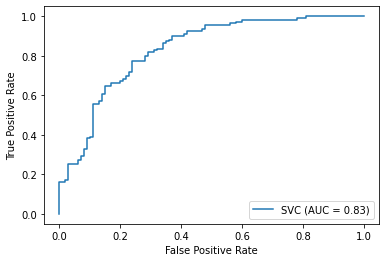

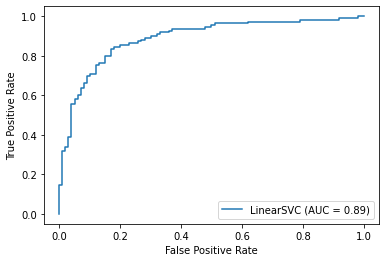

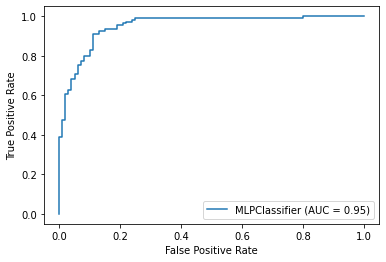

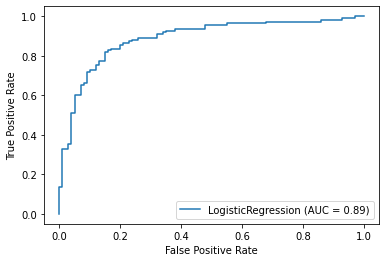

In [10]:
for model in best_models:
    plot_roc_curve(model, X_test[:, idx], y_test,
                   name=model['clf'].__class__.__name__)

# Task 2

In [25]:
# Load test data

test_dir_2 = 'Celeb-DF/evaluation/'
target_size_2 = (768, 768)

test_datagen_2 = ImageDataGenerator()

test_data_2 = test_datagen_2.flow_from_directory(
    directory=test_dir_2,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size_2,
)

num_test_2 = test_data_2.samples

Found 600 images belonging to 2 classes.


In [26]:
X_test_2, y_test_2 = extract_features(test_data_2, num_test_2, skip=False)
print("X_test_2:", X_test_2.shape)

X_test_2: (600, 204)


In [15]:
np.savez('data2', X_test=X_test_2, y_test=y_test_2)

In [8]:
data2 = np.load('data2.npz')
X_test_2, y_test_2 = data2['X_test'], data2['y_test']

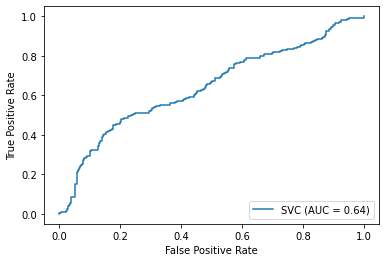

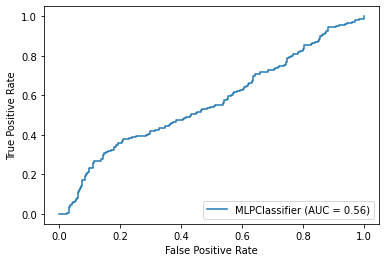

In [17]:
for model in [best_models[0], best_models[2]]:
    plot_roc_curve(model, X_test_2[:, idx], y_test_2,
                   name=model['clf'].__class__.__name__)